In [30]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

In [84]:
if torch.cuda.is_available():
    device = "cuda"
else:
    if torch.backends.mps.is_available():
        device = "mps"
    else:
        device="cpu"
device

'mps'

# Creating a Working Pokédex - Image Classification With Neural Network
## Summary
In recent years, artificial intelligence and computer vision have made significant advancements in image classification, enabling applications in fields such as medical diagnostics and autonomous vehicles. This project leverages the power of machine learning to develop a system capable of recognizing and classifying different Pokémon species, similar to the iconic 'Pokédex'. This notebook outlines the entire process, covering data collection, preprocessing, model selection, evaluation, deployment, and an analysis of the results.

The Pokémon franchise has captivated audiences for generations with its diverse range of creatures, making it an ideal subject for an engaging and practical machine learning application. Beyond its appeal to fans, building a Pokémon recognition system serves as a valuable demonstration of image classification techniques. Through this project, I aim to create an enjoyable and interactive tool for Pokémon enthusiasts while highlighting the real-world potential of machine learning in visual recognition tasks.

The primary objective of this project is to design and implement a neural network model that can take an image of a Pokémon and accurately identify its name/class. Specifically, my objectives include:

- Creating a comprehensive dataset containing images of various Pokémon species.
- Preprocessing and augmenting the dataset to make it suitable for training.
- Training a deep neural network model to identify Pokémon species from images.
- Evaluating the model's performance using appropriate metrics.
- Deploying an interactive Webapp to use the model
- Discussing the model's strengths, weaknesses, limitations, and potential areas for future improvement.

# Dataset

In the execution of this project, I have collected data from diverse sources to create a comprehensive dataset for training and evaluating our neural network models. The data gathered include images from various media, including screenshots from Pokémon games, official artwork, and fanart created by the Pokémon community.

My dataset was collated from two sources:

1. Kaggle Datasets:
I leveraged an many dataset available on [Kaggle](https://www.kaggle.com/). Those dataset serve as a foundational resource, providing a wide array of Pokémon images.

2. Google Images:
Additional images are sourced from the [Google Images Downloader Extension](https://chromewebstore.google.com/detail/download-all-images/nnffbdeachhbpfapjklmpnmjcgamcdmm)

After some tedious image selection I ended up with this final datset.

For now I am only predicting the names for the 3 starters of the first generation Bulbasaur, Squirtle, Charmander and also Pikachu. With time I will expand the range of possible Pokémons.

# Preprocessing Images

In [231]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
data_dir = 'data/train'

In [232]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5) , (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [233]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [234]:
dataset.classes

['Bulbasaur', 'Charmander', 'Pikachu', 'Squirtle']

In [235]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [236]:
print(f"Length of dataset: {len(dataset)}")
print(f"Type of dataset: {type(dataset)}")
dataset.class_to_idx

Length of dataset: 1602
Type of dataset: <class 'torchvision.datasets.folder.ImageFolder'>


{'Bulbasaur': 0, 'Charmander': 1, 'Pikachu': 2, 'Squirtle': 3}

# EDA

In [237]:
class_dict = {0:'Bulbasaur',1:'Charmander',2:'Pikachu',3:'Squirtle'}

In [238]:
import random
rand = random.randint(0,len(dataset)-1)
image, label = dataset[rand]

In [239]:
image.shape, label

(torch.Size([3, 64, 64]), 3)

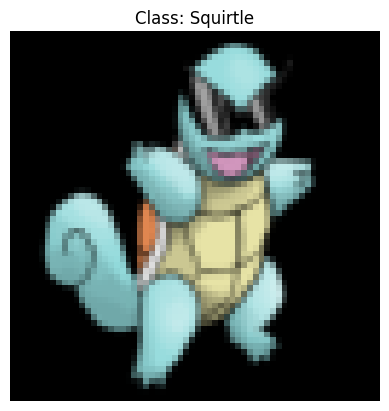

In [240]:
# Denormalize the image (undo normalization)
img = image.clone()  # Clone to avoid modifying the original tensor
img = img * 0.5 + 0.5  # Reverse normalization
img = img.clamp(0, 1)  # Ensure values are within valid range

# Convert tensor to NumPy and permute for matplotlib (C, H, W) → (H, W, C)
img = img.permute(1, 2, 0).numpy()

# Plot the image with its class label
plt.imshow(img)
plt.title(f"Class: {class_dict[label]}")
plt.axis("off")
plt.show()

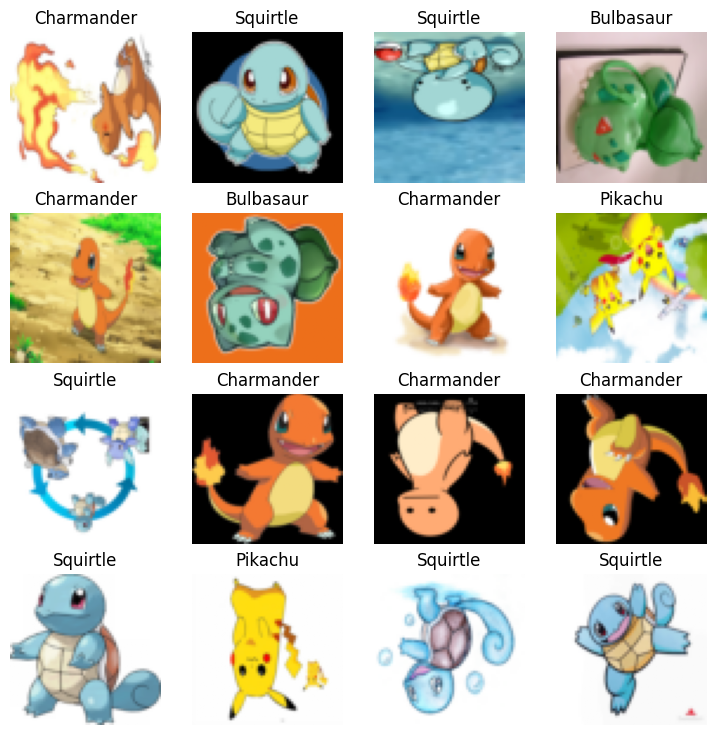

In [241]:
# Plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(dataset), size=[1]).item()
    img, label = dataset[random_idx]
    img = img * 0.5 + 0.5
    img = img.permute(1, 2, 0).numpy()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_dict[label])
    plt.axis(False)

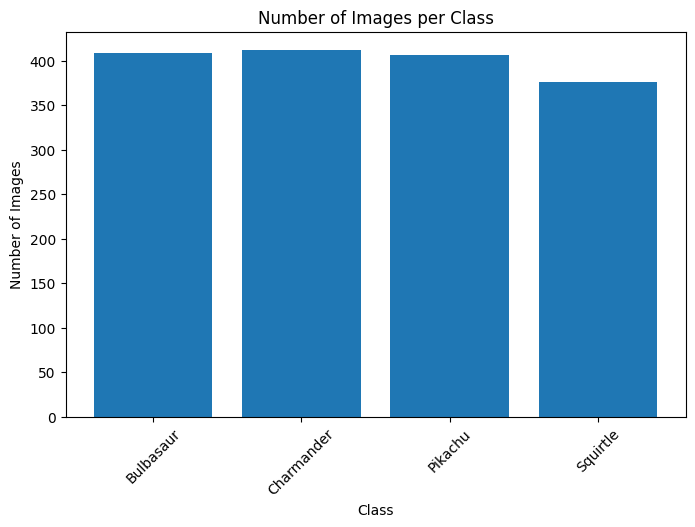

In [242]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each class
class_counts = Counter(dataset.targets)

# Get class names
class_names = [key for key in dataset.class_to_idx.keys()]
counts = [class_counts[idx] for idx in dataset.class_to_idx.values()]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()

# Dataloader

In [243]:
dataloader = DataLoader(dataset, shuffle=True,batch_size=4)
print(f"Length of dataoader: {len(dataloader)} batches of 4")

Length of dataoader: 401 batches of 4


In [244]:
for images, labels in dataloader:
    print(images.shape)  # Batch of image tensors (e.g., [32, 3, 64, 64])
    print(labels.shape)        # Corresponding labels (e.g., [0, 1, 0, ...])
    break  # Check one batch


torch.Size([4, 3, 64, 64])
torch.Size([4])


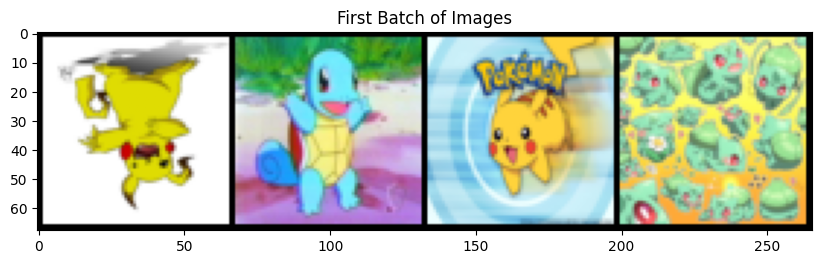

In [245]:
# Get a batch of images and labels
images, labels = next(iter(dataloader))  # Get the first batch

# Denormalize the images to bring pixel values back to [0, 1]
images = images * 0.5 + 0.5  # Reverse the normalization: (x * std) + mean

# Create a grid of images to display
grid = torchvision.utils.make_grid(images[:32], nrow=8)  # Display first 8 images in a 8x4 grid

# Plot the images
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))  # Change dimensions for plotting (C, H, W -> H, W, C)
plt.title("First Batch of Images")
plt.show()

# CNN Model

In [246]:
from torch import nn
conv_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
conv_img = conv_layer(image)

In [247]:
image.shape,conv_img.shape

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]))

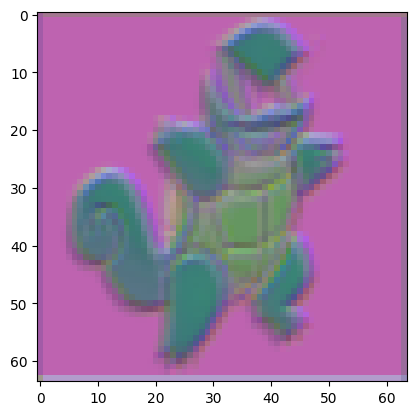

In [248]:
conv_img = conv_img * 0.5 + 0.5
conv_img = conv_img.permute(1, 2, 0).detach().numpy()
plt.imshow(conv_img)

In [249]:
max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
mpl_img = max_pool_layer(image)

In [250]:
image.shape,mpl_img.shape

(torch.Size([3, 64, 64]), torch.Size([3, 32, 32]))

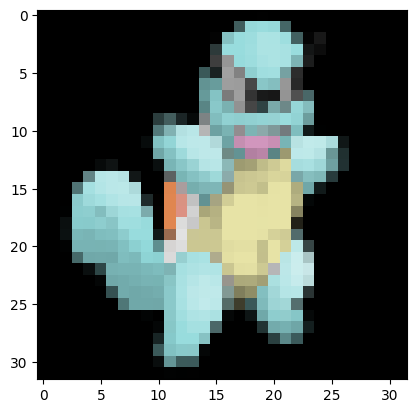

In [251]:
i = mpl_img * 0.5 + 0.5
i = i.permute(1, 2, 0)
plt.imshow(i)

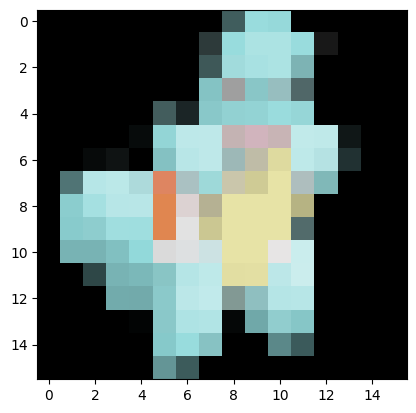

In [252]:
mpl_img = max_pool_layer(mpl_img)
i = mpl_img * 0.5 + 0.5
i = i.permute(1, 2, 0)
plt.imshow(i)

In [253]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layer: Input (3, 64, 64), Output (16, 64, 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Output: (64, 32, 32)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Flattening after pooling (16x16 spatial size)
        self.fc2 = nn.Linear(128,num_classes)  # Final output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU after Conv1
        x = self.pool(x)  # Apply pooling
        x = F.relu(self.conv2(x))  # Apply ReLU after Conv2
        x = self.pool(x)  # Apply pooling again
        x = torch.flatten(x, 1)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer
        x = self.fc2(x)  # Output layer
        return x

In [254]:
LEARNING_RATE = 0.001
EPOCHS = 10
HIDDEN_UNITS = 64
INPUT_SHAPE = 3
NUM_CLASSES = len(dataset.class_to_idx)

In [255]:
cnn1_model = SimpleCNN(num_classes=NUM_CLASSES)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn1_model.parameters(), lr=LEARNING_RATE)

In [256]:
cnn1_model = cnn1_model.to(device)
# Training Loop
for epoch in range(EPOCHS):
    cnn1_model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in dataloader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = cnn1_model(images)
        loss = loss_function(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        # Track loss
        running_loss += loss.item()

    # Print average loss per epoch
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(dataloader):.4f}")

print("Training complete!")

Epoch [1/10], Loss: 1.2770
Epoch [2/10], Loss: 0.9302
Epoch [3/10], Loss: 0.6876
Epoch [4/10], Loss: 0.5362
Epoch [5/10], Loss: 0.4498
Epoch [6/10], Loss: 0.3998
Epoch [7/10], Loss: 0.3757
Epoch [8/10], Loss: 0.3614
Epoch [9/10], Loss: 0.3392
Epoch [10/10], Loss: 0.3277
Training complete!


# Testing Loop

In [257]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

sample_image_path = "data/PokemonData/Charmander/3e83165adc794c52b6fed8804b3d1678.jpg"

# Apply the same transformations as during training
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image = Image.open(sample_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Move the image to the same device as the model
input_tensor = input_tensor.to(device)

# Put the model in evaluation mode
cnn1_model.eval()

# Perform inference
with torch.no_grad():
    output = cnn1_model(input_tensor)  # Forward pass
    predicted_class = torch.argmax(output, dim=1).item()  # Get the class index



In [258]:
predicted_class

1

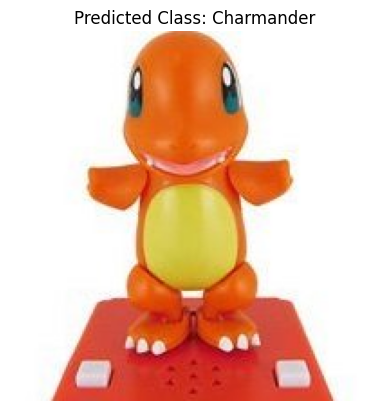

In [259]:
predicted_label = class_dict[predicted_class]

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_label}")
plt.axis("off")
plt.show()


## Metrics

In [269]:
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the test dataset from your folder
test_folder = "data/test"
test_dataset = datasets.ImageFolder(root=test_folder, transform=test_transforms)

# Test DataLoader (batch_size=1 for individual inference)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

cnn1_model.eval()
# Define class names (ensure they match training)
class_names = test_dataset.classes  # Automatically loads class names from folder structure

# Run the test loop
correct = 0
total = 0

with torch.no_grad():  # No gradients needed for inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = cnn1_model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class

        # Calculate accuracy
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        print(f"Predicted: {class_names[preds.item()]}, Actual: {class_names[labels.item()]}")

# Print final accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Bulbasaur, Actual: Bulbasaur
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Pikachu, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Charmander, Actual: Charmander
Predicted: Pikachu, Actual: Charmander
Predicted: Pikachu, Actual: Pikachu
Predicted: Pikachu, Actual

In [270]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []
cnn1_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = cnn1_model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.append(labels.item())
        y_pred.append(preds.item())

# Compute Precision, Recall, F1-score
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.9428
Recall: 0.9348
F1-Score: 0.9344


In [271]:
torch.save(cnn1_model.state_dict(), "models/cnn1.pth")

# Try out different base models (Transfer Learning) DenseNet and ResNet